Librerias útiles

In [26]:
import numpy as np
#para las unidades
from astropy import units as u
from astropy import constants as C
#para graficar
import matplotlib.pyplot as plt
#barras de avance
from tqdm.auto import tqdm
#integracion
import scipy.integrate as integrate
from scipy.integrate import simps

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#Tasa de eventos diferencial 
se deduce como la distribucion de duración de eventos de microlente 
\begin{equation}
    \frac{d\Gamma}{d\hat{t}}= 2D_S \int_{0}^{1}dx \frac{\rho(x)}{Mv_c^2}v_E^4 \, \exp{\left(-\frac{v_E^2}{v_c^2}\right)}
\end{equation}

El perfil que describa a los objetos del halo de la galaxia vendra dado por uno de esfera isótropo, isotermo y no singular de la siguiente forma
\begin{equation}
    \rho_{isot}(R) = \rho_{\odot} \frac{R_{Sol}^2+R_C^2}{R_C^2+R^2} \,,
\end{equation}
con $\rho_{\odot} = 0.0097M_{\odot}\text{pc}^{-3}$,  $R_C= 5$kpc el radio del core de la galaxia y $R_{Sol}=8.5$ kpc la distancia del Sol al centro de la galaxia.

Por otro lado, $v_E = R_E(x)/t_E$

Defino algunas funciones para calcular la tasa de eventos diferencial

In [27]:
def rE(m, x, D):
    ''' 
    Radio de Einstein.
    Entradas:
    m: masa de la lente.
    x: D_OL/D distancia a la lente normalizada por la distancia a la fuente.
    D: Distancia a la fuente.
    '''
    arg = (4*C.G*(m*C.M_sun)*(D*u.kpc)*x*(1-x)/(C.c**2)).decompose()
    rE = np.sqrt(abs(arg)).decompose()
    return rE

def r(x):
    '''
    Distancia a la fuente.
    Entradas:
    x: D_OL/D distancia a la lente normalizada por la distancia a la fuente.
    '''
    R0 = 8.5*u.kpc
    L = 50*u.kpc
    b, l = -32.8*(np.pi/180), 281*(np.pi/180)
    return np.sqrt((x*L)**2 +(R0)**2 - 2*R0*L*x*np.cos(b)*np.cos(l))

def rho(x):
    '''
    Perfil de esfera isoterma para los objetos del halo de la galaxia.
    '''
    R0 = 8.5*u.kpc
    Rc = 5*u.kpc
    return (0.0079*(R0**2+Rc**2)/(r(x)**2+Rc**2)*C.M_sun/u.pc**3).decompose()

def integrand(x,t,m):
    '''
    Integrando de la tasa de eventos diferencial.
    El objetivo será La Gran Nube de Magallanes.
    '''
    vc=220*u.km/u.s
    d = 50 #kpc
    D =d*u.kpc
    Q = ((4*rE(m,x,d)**2)/(t*u.year*vc)**2).decompose()
    exp_fac = np.exp(-Q)
    factor = 32*D/((m*C.M_sun)*(t*u.year)**4 * vc**2)
    return ((factor)*rho(x)*exp_fac*rE(m,x,d)**4*u.year**2).decompose()

def event_rate(t,m):
    '''
    Tasa de eventos diferencial.
    '''
    return integrate.fixed_quad(lambda x: integrand(x,t,m), 0, 1,n=1000)[0]


In [28]:
t_hat = np.logspace(-10, 4, 100)
m     = [1e-2,1e-1,1]  #masas de las lentes

In [29]:
rates = np.zeros([len(t_hat),len(m)])
for j in tqdm(range(len(m))):
    for i in range(len(t_hat)):
        rates[i,j] = event_rate(t_hat[i],m[j])

  0%|          | 0/3 [00:00<?, ?it/s]

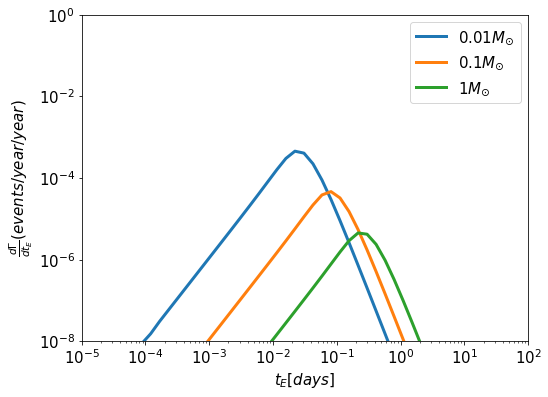

In [30]:
#@title Los maximos corresponden a la duración de eventos más probables.
plt.figure(figsize=(8,6))
ax = plt.axes()
plt.ylim(1e-8,1)
plt.xlim(1e-5,1e2)

plt.loglog(t_hat, rates[:,0], lw=3, label=str(round(m[0],2))+r'$M_{\odot}$')
plt.loglog(t_hat, rates[:,1], lw=3,label=str(round(m[1],2))+r'$M_{\odot}$')
plt.loglog(t_hat, rates[:,2], lw=3,label=str(round(m[2],2))+r'$M_{\odot}$')

plt.ylabel(r'$\frac{d\Gamma}{dt_E}(events/year/year)$',fontsize=15)
plt.xlabel(r'$t_E [days]$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best' ,fontsize=15)

# La eficiencia es la probabilidad de detectar un evento de microlente.

Eficiencia que se va a utilizar, puede ser una asociada a una observación de mas de 400 dias. 


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

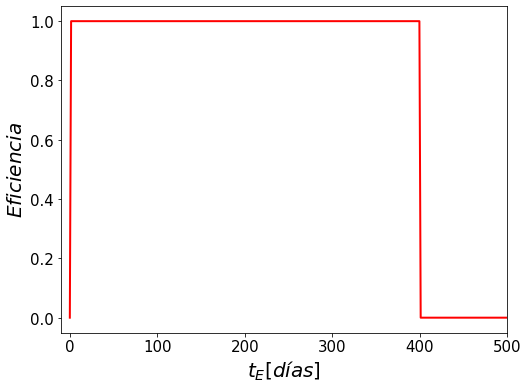

In [31]:
tE = np.linspace(0,365*2,500)

ef = [] 
for t in tE:
    if t<1e-2:
        ef.append(0)
    elif t>400:
        ef.append(0)
    else:
        ef.append(1)
plt.figure(figsize=(8,6))
plt.xlim(-10,500)
plt.plot(tE, ef, '-',color='red',lw=2)
plt.ylabel(r'$Eficiencia$',fontsize=20)
plt.xlabel(r'$t_E [días]$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


#Numero esperado de eventos

Integrando la tasa de eventos junto a la eficiencia, para todos los tiempos de cruce de Einstein posibles, y
considerando el número de estrellas observadas, se consigue el número esperado de eventos
\begin{equation}
    N_{exp} = E\int_0^{\infty} \mathcal{E}(\hat{t})\frac{d\Gamma}{d\hat{t}}d\hat{t} 
\end{equation}
Aquí $\mathcal{E}(\hat{t})$ es la eficiencia de detección, la cual, como se mencionó previamente, da la probabilidad de que en una observación particular se detecte un evento de microlente. $E=N_{\text{estrellas}} \times T_{\text{observación}}$ es la exposición, o sea, el número total de estrellas monitoreadas en un cierto tiempo (i.e. para las cuales se puede obtener la curva de luz). Para EROS-2 la exposición es $E_{LMC}=10^{7}$ estrellas-años.

In [32]:
t_hat = np.logspace(-10, 4,100)
M     = np.logspace(-10,10,100)

N = []
rates_int = np.zeros([len(t_hat),len(M)])
for j in tqdm(range(len(M))):
    for i in range(len(t_hat)):
        if t_hat[i]<1e-2:
            rates_int[i,j] = 0
        elif t_hat[i]>400:
            rates_int[i,j] = 0
        else:
            rates_int[i,j] = event_rate(t_hat[i],M[j])
    Nexp = simps(rates_int[:,j], t_hat)
    N.append(Nexp)
N = np.array(N)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'N exp')

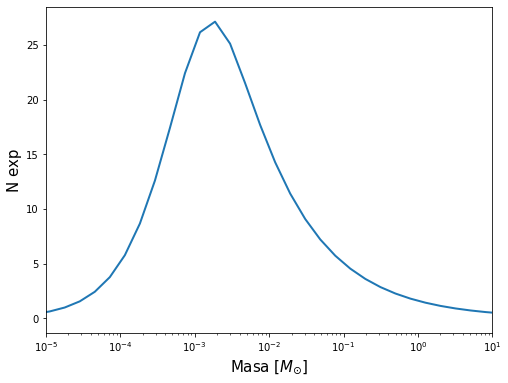

In [33]:
E =1e+6 #exposure (star-years)
plt.figure(figsize=(8,6))
plt.xlim(1e-5,1e1)
plt.semilogx(M,E*N, lw=2)
plt.xlabel(r'Masa $[M_{\odot}]$', fontsize=15)
plt.ylabel(r'N exp', fontsize=15)

#Limites en la fracción de materia oscura que pueden ser PBH
El método para obtener las cotas sobre la fracción de materia oscura que pueden ser PBH (DCO) se hace, suponiendo que los eventos detectados siguen una distribución de Poisson.

La probabilidad de observar un número $N_{obs}$ de eventos de microlente debido a DCO, sabiendo que $N_{exp}$ es el número de veces que se espera que ocurra el evento es
\begin{equation}
    P(N_{obs}|N_{exp}) = \frac{(N_{exp})^{N_{obs}}}{N_{obs}!}e^{-N_{exp}}\,.
\end{equation}
El número de eventos que contribuirán a los eventos producidos por objetos oscuros compactos del halo será una fracción del total $N_{exp}$, que fue el calculado en la sección anterior
\begin{equation}
    N_{exp}^{PBH} = f_{DM}N_{exp} \,.
\end{equation}
Dicho de otra forma, $f_{DM}$ es la fracción de la materia oscura que estará en la forma de DCO y se puede escribir como $f_{DM} = \frac{\Omega_{DCO}}{\Omega_{DM}}$, donde $\Omega_{DCO}$ es la fracción cosmológica de materia oscura en la forma objetos oscuros compactos y $\Omega_{DM}$ es la fracción total de materia oscura. 
 
A partir de la estimación del número esperado de eventos para cada masa se calcula la fracción más grande del halo en forma de objetos compactos que sea un $95\%$ compatible con la detección de $k$ eventos. Entonces, uno puede excluir la región de parámetros haciendo
\begin{equation}
    \sum_{k=0}^{N_{obs}} P(k|N_{exp}^{PBH})<0.05
\end{equation}
con un dado $N_{obs}$ correspondiente al $95\%$ de nivel de confianza.

Suponiendo que la observacion a LMC no detecto ningun evento asociado a un PBH el cual fue el caso EROS-2, un survey que realizó observaciones hacia LMC. Ese experimento no detectó ningún evento. La probabilidad de que eso ocurra es
\begin{equation}
    P(0|N_{exp}^{PBH}) = e^{-f_{DM}N_{exp}}.
\end{equation}
Los límites sobre $f_{DM}$ se obtienen pidiendo que $f_{DM}>f_{95CL}$ lo que implica que $P(0|N_{exp}^{PBH})<0.05$. Esta condición excluye $N_{exp}^{PBH}\gtrsim 3$ con un 95$\%$CL. Entonces calculamos el valor para el cual $f_{DM}=f_{95CL}$, en el caso de no haber observado eventos
\begin{equation}
    f_{95CL} = \frac{-\ln(0.05)}{N_{exp}} \approx \frac{3.0}{N_{exp}}.
\end{equation}


Text(0, 0.5, '$f=\\frac{\\Omega_{PBH}}{\\Omega_{DM}}$')

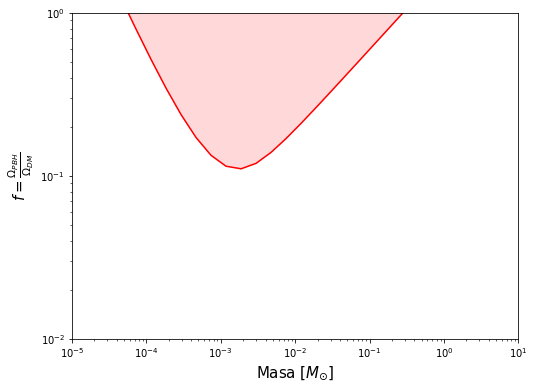

In [34]:
plt.figure(figsize=(8,6))
plt.ylim(1e-2,1)
plt.xlim(1e-5,1e1)
plt.loglog(M,3.0/(E*N),color='red')
plt.fill_between(M,3/(E*N),1,color='red', alpha=0.15)
plt.xlabel(r'Masa [$M_{\odot}$]', fontsize =15)
plt.ylabel(r'$f=\frac{\Omega_{PBH}}{\Omega_{DM}}$', fontsize =15)